# Demo
A demonstration notebook showing off how to use the `dmv.data.DataContainer` and the `dmv.layer.DynamicMultiViewRNN`.

In [1]:
import os
import datetime
import seaborn as sb
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa

tf.keras.backend.set_floatx('float32')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Settings

In [2]:
data_folder = r'C:\Users\jeroe\data\MURA\MURA-v1.1'
multi = True
img_shape = [128, 128, 3]

## Augmentation

In [3]:
train_augmentation = {
    'rotation': 30,
    'horizontal_flip': True,
}

## Data

In [4]:
from dmv.data import DataContainer

train_dc = DataContainer(data_folder, train=True, multi=multi, category="Humerus", batch_size=8, output_shape=img_shape, augmentation=train_augmentation)
valid_dc = DataContainer(data_folder, train=False, multi=multi, category="Humerus", batch_size=8, output_shape=img_shape)

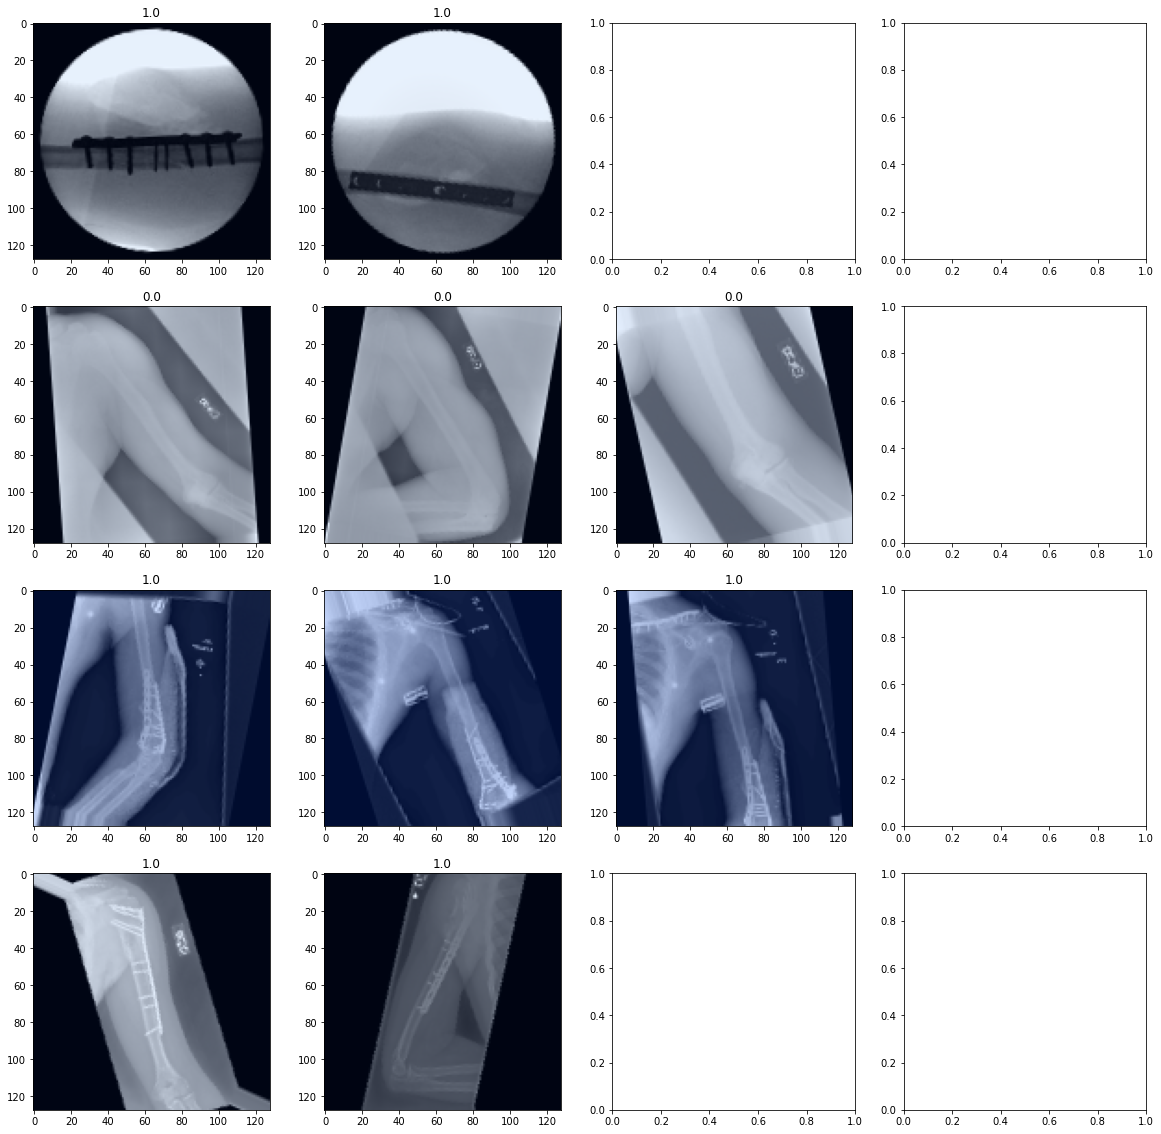

In [5]:
train_dc.show(figsize=(20,20))

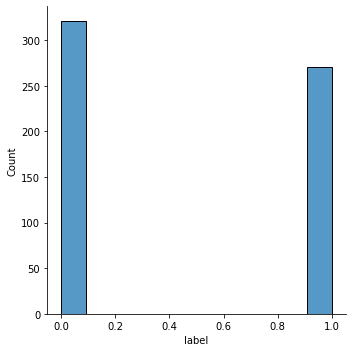

In [6]:
sb.displot(train_dc.df, x='label')

## Model

In [19]:
#from tensorflow.keras.applications import DenseNet169, DenseNet121
from ebl.dense import DenseNet121
from tensorflow.keras.layers import Dense, TimeDistributed, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras import Model

from dmv.layer import DynamicMultiViewRNN

class DynamicMultiViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
        
        for layer in self.base.layers:
            layer.trainable = False
        
        
        
        self.agg = DynamicMultiViewRNN()
        self.batchnorm = BatchNormalization()
        self.dropout = Dropout(.5)
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
    
    def call(self, x):

        x = TimeDistributed(self.base)(x)
        x = self.agg(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.classify(x)

        return x

In [20]:
class SingleViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet169(include_top=False, input_shape=input_shape, pooling='avg')
        for layer in self.base.layers:
            layer.trainable = True
        
        #self.dense = Dense(50, activation='relu', name='dense_after_flatten')
        #self.dropout = Dropout(.5)
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
    
    def call(self, x):
        x = self.base(x)
        #x = self.dropout(x)
        #x = self.dense(x)
        #x = self.dropout(x)
        x = self.classify(x)
        
        return x

## Instantiating

In [21]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

if multi:
    model = DynamicMultiViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.0001, beta_1=0.9, beta_2=0.999),
        metrics=[
            'accuracy',
            tfa.metrics.CohenKappa(num_classes=2)
        ],
        loss=BinaryCrossentropy()
    )
else:
    model = SingleViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.0001, beta_1=0.9, beta_2=0.999),
        metrics=[
            'accuracy',
            tfa.metrics.CohenKappa(num_classes=2)
        ],
        loss=BinaryCrossentropy()
    )
    

        
model.summary()

428
input_4 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002734977E0B8>
zero_padding2d_6 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000002734977E4E0>
conv1/conv <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002734977E588>
conv1/bn <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002734977E978>
conv1/relu <tensorflow.python.keras.layers.core.Activation object at 0x000002734977EF60>
zero_padding2d_7 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000002734978C0F0>
pool1 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000273497819B0>
conv2_block1_0_bn <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000273497A15C0>
conv2_block1_0_relu <tensorflow.python.keras.layers.core.Activation object at 0x00000273497A1C50>
conv2_block1_1_conv <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000273497

## Callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

log_dir = os.path.join('D:\Files\logs\capita')
log_record_dir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_record_dir, histogram_freq=1)
print(f'Tensorboard logs available on: {log_dir}')

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

Tensorboard logs available on: D:\Files\logs\capita


## Training

In [11]:
class_weights = {
    0: len(train_dc.df[train_dc.df['label'] == 1]) / len(train_dc.df),
    1: len(train_dc.df[train_dc.df['label'] == 0]) / len(train_dc.df),
}

In [12]:
model.fit(
    x=train_dc.ds(),
    steps_per_epoch=train_dc.batches_per_epoch,
    validation_data=valid_dc.ds(),
    validation_steps=valid_dc.batches_per_epoch,
    epochs=50,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop, reduce_lr]
)

Epoch 1/50
 1/74 [..............................] - ETA: 0s - loss: 0.3398 - accuracy: 0.6250 - cohen_kappa: 0.3333WARNING:tensorflow:From D:\Files\Documents\Anaconda\envs\capita\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
74/74 [==============================] - 18s 239ms/step - loss: 0.3883 - accuracy: 0.5659 - cohen_kappa: 0.1293 - val_loss: 0.5382 - val_accuracy: 0.7556 - val_cohen_kappa: 0.5115
Epoch 2/50
74/74 [==============================] - 10s 134ms/step - loss: 0.3539 - accuracy: 0.6267 - cohen_kappa: 0.2530 - val_loss: 0.4452 - val_accuracy: 0.7704 - val_cohen_kappa: 0.5410
Epoch 3/50
74/74 [==============================] - 10s 132ms/step - loss: 0.3232 - accuracy: 0.7027 - cohen_kappa: 0.4039 - val_loss: 0.4247 - val_accuracy: 0.7778 - val_cohen_kappa: 0.5551
Epoch 4/50
74/74 [========